# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [74]:
import pandas as pd
import numpy as np
import math
import json
% matplotlib inline
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [3]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [4]:
profile.head()

,age,became_member_on,gender,id,income
0,118,20170212,None,68be06ca386d4c31939f3a4f0e3dd783,NaN
1,55,20170715,F,0610b486422d4921ae7d2bf64640c50b,112000.0
2,118,20180712,None,38fe809add3b4fcf9315a9694bb96ff5,NaN
3,75,20170509,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0
4,118,20170804,None,a03223e636434f42ac4c3df47e8bac43,NaN


In [75]:
def clean_portfolio(portfolio):
    '''
    data cleaning the portfolio dataframe
    
    INPUT:
    portfolio - the portfolio dataframe to be cleaned
    
    OUTPUT:
    portfolio - the cleaned portfolio dataframe
    
    '''
    # change the duration from day to hour
    cleaned_portfolio = portfolio.copy()
    cleaned_portfolio['duration'] = cleaned_portfolio['duration'] * 24
    
    # apply one hot encoding to channels column
    cleaned_portfolio['web'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'web' in x else 0)
    cleaned_portfolio['email'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'email' in x else 0)
    cleaned_portfolio['mobile'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'mobile' in x else 0)
    cleaned_portfolio['social'] = cleaned_portfolio['channels'].apply(lambda x: 1 if 'social' in x else 0)
    
    # apply one hot encoding to offer_type column
    offer_type = pd.get_dummies(cleaned_portfolio['offer_type'])
    
    # drop the channels and offer_type column
    cleaned_portfolio.drop(['channels', 'offer_type'], axis=1, inplace=True)
    
    # combine the portfolio and offer_type dataframe to form a cleaned dataframe
    cleaned_portfolio = pd.concat([cleaned_portfolio, offer_type], axis=1, sort=False)
    
    return cleaned_portfolio

In [76]:
cleaned_portfolio = clean_portfolio(portfolio)

In [6]:
for i in all_channels:
    portfolio[i]= portfolio['channels'].apply(lambda x:1 if i in x else 0)
portfolio.drop('channels', axis = 1,inplace = True)
cols = ['difficulty', 'duration', 'reward']

for col in cols:
    portfolio[col] = portfolio[col].apply(lambda x:int(x))
                                          

                                          
portfolio.head()

,difficulty,duration,id,offer_type,reward,email,mobile,social,web
0,10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10,1,1,1,0
1,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10,1,1,1,1
2,0,4,3f207df678b143eea3cee63160fa8bed,informational,0,1,1,0,1
3,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5,1,1,0,1
4,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5,1,0,0,1


In [7]:
len(np.unique(portfolio['id']))

10

In [8]:
len(portfolio)

10

In [9]:
profile['gender'].fillna('U',inplace = True)
profile['income'] = profile['income'].apply(lambda x : float(x))
profile['age'] = profile['age'].apply(lambda x : int(x))

In [10]:
profile['income']

0             NaN
1        112000.0
2             NaN
3        100000.0
4             NaN
5         70000.0
6             NaN
7             NaN
8         53000.0
9             NaN
10            NaN
11            NaN
12        51000.0
13        57000.0
14        46000.0
15        71000.0
16        52000.0
17            NaN
18        42000.0
19        40000.0
20        71000.0
21       100000.0
22        71000.0
23            NaN
24        69000.0
25        88000.0
26            NaN
27        52000.0
28        59000.0
29        41000.0
           ...   
16970     94000.0
16971     75000.0
16972     51000.0
16973     57000.0
16974     71000.0
16975     81000.0
16976     54000.0
16977         NaN
16978     58000.0
16979     52000.0
16980         NaN
16981     93000.0
16982         NaN
16983     65000.0
16984     78000.0
16985     55000.0
16986     63000.0
16987     40000.0
16988     51000.0
16989         NaN
16990     39000.0
16991         NaN
16992     72000.0
16993    113000.0
16994     

In [11]:
mean_val = profile.income.mean()
mean_val

65404.991568296799

In [12]:
profile['income'].fillna(mean_val, inplace = True)

In [13]:
profile['income'].head()

0     65404.991568
1    112000.000000
2     65404.991568
3    100000.000000
4     65404.991568
Name: income, dtype: float64

In [14]:
profile['mem_year'] = profile.became_member_on.apply(lambda x : int(str(x)[:4]))
profile['mem_month'] = profile.became_member_on.apply(lambda x : int(str(x)[4:6]))
profile['mem_day'] = profile.became_member_on.apply(lambda x : int(str(x)[6:]))
profile['mem_date'] = profile.became_member_on.apply(lambda x : datetime.datetime.strptime(str(x), '%Y%m%d'))

In [15]:
profile.drop('became_member_on', axis = 1, inplace = True)

In [16]:
profile.head()

,age,gender,id,income,mem_year,mem_month,mem_day,mem_date
0,118,U,68be06ca386d4c31939f3a4f0e3dd783,65404.991568,2017,2,12,2017-02-12
1,55,F,0610b486422d4921ae7d2bf64640c50b,112000.000000,2017,7,15,2017-07-15
2,118,U,38fe809add3b4fcf9315a9694bb96ff5,65404.991568,2018,7,12,2018-07-12
3,75,F,78afa995795e4d85b5d9ceeca43f5fef,100000.000000,2017,5,9,2017-05-09
4,118,U,a03223e636434f42ac4c3df47e8bac43,65404.991568,2017,8,4,2017-08-04


Text(0.5,0,'gender')

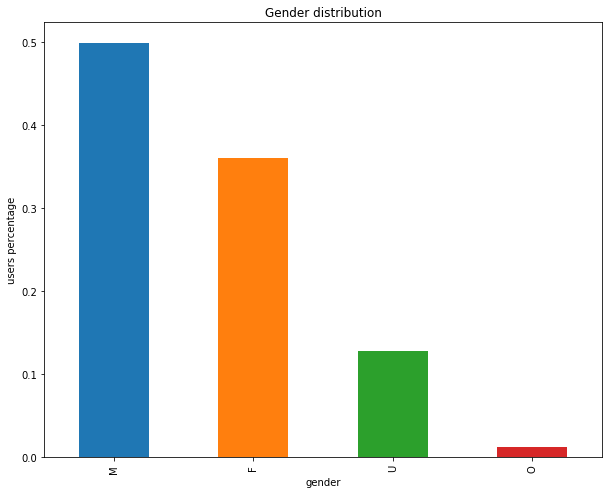

In [17]:
profile.gender.value_counts(normalize = True).plot('bar', figsize = (10,8))
plt.title('Gender distribution')
plt.ylabel('users percentage')
plt.xlabel('gender')

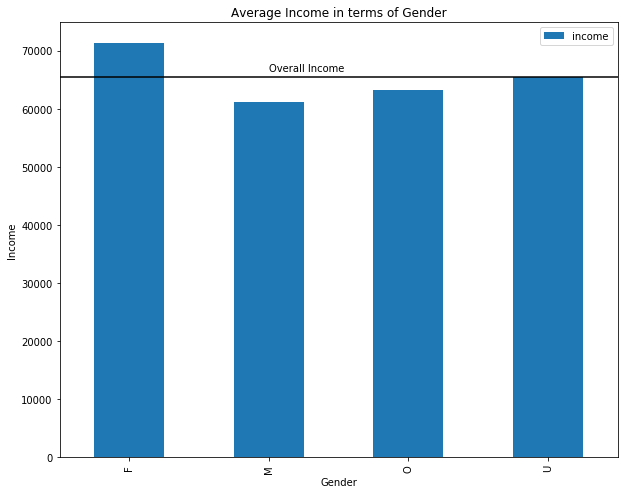

In [18]:
income_by_gender = profile.groupby('gender').agg({'income':'mean'})
income_by_gender.plot(kind = 'bar', figsize = (10,8))
plt.hlines(mean_val, -100 , 1000)
plt.ylabel('Income')
plt.xlabel('Gender')
plt.title('Average Income in terms of Gender')
plt.text(1, mean_val + 1000, 'Overall Income');

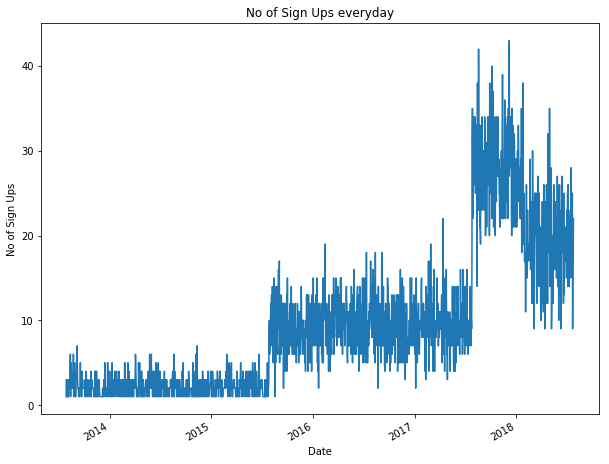

In [19]:
profile.mem_date.value_counts().plot(kind = 'line', figsize = (10,8))
plt.xlabel('Date')
plt.ylabel('No of Sign Ups')
plt.title('No of Sign Ups everyday');

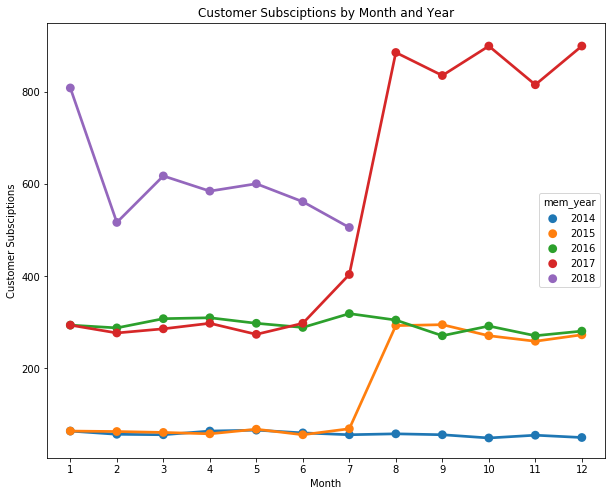

In [20]:
mem_subs = profile[profile['mem_year'] >= 2014].groupby(['mem_year','mem_month'], as_index=False).agg({'id':'count'})
plt.figure(figsize=(10,8))
sns.pointplot(x="mem_month", y="id", hue="mem_year", data = mem_subs)
plt.ylabel('Customer Subsciptions')
plt.xlabel('Month')
plt.title('Customer Subsciptions by Month and Year');

In [21]:
transcript['event'].unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'], dtype=object)

In [22]:
transcript.head()

,event,person,time,value
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'}
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}


In [23]:
transcript[transcript['person']=='a03223e636434f42ac4c3df47e8bac43']

,event,person,time,value
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
15562,offer viewed,a03223e636434f42ac4c3df47e8bac43,6,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
90553,transaction,a03223e636434f42ac4c3df47e8bac43,234,{'amount': 1.09}
97700,transaction,a03223e636434f42ac4c3df47e8bac43,264,{'amount': 3.5}
110829,offer received,a03223e636434f42ac4c3df47e8bac43,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
123539,offer viewed,a03223e636434f42ac4c3df47e8bac43,336,{'offer id': '3f207df678b143eea3cee63160fa8bed'}
150599,offer received,a03223e636434f42ac4c3df47e8bac43,408,{'offer id': '5a8bc65990b245e5a138643cd4eb9837'}
201573,offer received,a03223e636434f42ac4c3df47e8bac43,504,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
245125,offer received,a03223e636434f42ac4c3df47e8bac43,576,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}
277104,transaction,a03223e636434f42ac4c3df47e8bac43,612,{'amount': 0.06}


In [24]:

def clean_transcript(transcript):
    '''
    data cleaning the transcript dataframe, return usable dataframe need contain offer events
    
    INPUT:
    transcript - the transcript dataframe to be cleaned
    
    OUTPUT:
    offer - the cleaned offer dataframe
    
    '''
    # extract the rows that are related to offer action (e.g. offer received, offer viewed, offer completed)
    offer = transcript[transcript['value'].apply(lambda x: True if ('offer id' in x) or ('offer_id' in x) else False)]
    
    # extract the offer id from value column
    offer['offer_id'] = offer['value'].apply(lambda x: x['offer id'] if ('offer id' in x) else x['offer_id'])
    
    return offer

In [25]:
offer = clean_transcript(transcript)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
offer.head()

,event,person,time,value,offer_id
0,offer received,78afa995795e4d85b5d9ceeca43f5fef,0,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},9b98b8c7a33c4b65b9aebfe6a799e6d9
1,offer received,a03223e636434f42ac4c3df47e8bac43,0,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0b1e1539f2cc45b7b9fa7c272da2e1d7
2,offer received,e2127556f4f64592b11af22de27a7932,0,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},2906b810c7d4411798c6938adc9daaa5
3,offer received,8ec6ce2a7e7949b1bf142def7d0e0586,0,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},fafdcd668e3743c1bb461111dcafc2a4
4,offer received,68617ca6246f4fbc85e91a2a49552598,0,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},4d5c57ea9a6940dd891ad53e9dbe8da0


In [28]:
def create_user_item_matrix(offer, filename):    
    '''
    Return the user item matrix that indicate the number of offer complete of a particular user
    
    INPUT:
    offer - a cleaned transcript dataframe
    filename(string) - the file name that save the user item matrix
    
    OUTPUT:
    user_item_matrix - the user item matrix which 
        - row is user 
        - column is offer
        - value is the number of offer complete by the user (NaN means no offer given)
    
    '''
    # create an empty user item matrix
    user_item_matrix = offer.groupby(['person', 'offer_id'])['event'].agg(lambda x: np.nan).unstack()
    # we just focus on bogo and discount first
    user_item_matrix.drop(list(portfolio[portfolio['offer_type']=='informational']['id']), axis=1, inplace=True)
    
    for offer_id in user_item_matrix.columns:
        print("Now processing: ", offer_id)
        num = 0
        for person in user_item_matrix.index:
            num += 1
            if num % 1000 == 0:
                print("finished ", num/16994*100, '%')
            events = []
            for event in offer[(offer['offer_id']==offer_id) & (offer['person']==person)]['event']:
                events.append(event)
            if len(events) >= 3:
                user_item_matrix.loc[person, offer_id] = 0
                for i in range(len(events)-2):
                    # check if the transaction sequence is offer received -> offer viewed -> offer completed
                    # if yes, we assume the user reacted positively with the offer we provided.
                    if (events[i] == 'offer received') & (events[i+1] == 'offer viewed') & (events[i+2] == 'offer completed'):
                        user_item_matrix.loc[person, offer_id] += 1
            elif len(events) > 0:
                user_item_matrix.loc[person, offer_id] = 0
    ,
    # store the large martix into file
    fh = open(filename, 'wb')
    pickle.dump(user_item_matrix,fh)
    fh.close()
    return user_item_matrix

In [29]:
full_df = create_user_item_matrix(offer, 'user_item_matrix.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [35]:
full_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,1.0,1.0,NaN,NaN,1.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,1.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN


In [36]:
train_siz = int(offer.shape[0]*0.7)
test_siz = offer.shape[0] - train_siz
train_siz, test_siz

(117306, 50275)

In [37]:
train_off = offer[:train_siz]


In [38]:
test_off = offer[train_siz:]

In [39]:
train_df = create_user_item_matrix(train_off, 'train_df.p')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
finished  94.15087678004002 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253

In [40]:
train_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,1.0,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,0.0,NaN,1.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN,NaN,0.0,NaN,1.0,NaN


In [41]:
test_df = create_user_item_matrix(test_off, ' test_df.p ')

Now processing:  0b1e1539f2cc45b7b9fa7c272da2e1d7
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128752 %
Now processing:  2298d6c36e964ae4a3e7e9706d1fb8c2
finished  5.884429798752501 %
finished  11.768859597505003 %
finished  17.653289396257502 %
finished  23.537719195010006 %
finished  29.422148993762505 %
finished  35.306578792515005 %
finished  41.19100859126751 %
finished  47.07543839002001 %
finished  52.95986818877251 %
finished  58.84429798752501 %
finished  64.7287277862775 %
finished  70.61315758503001 %
finished  76.4975873837825 %
finished  82.38201718253502 %
finished  88.26644698128

In [42]:
test_df.head()

offer_id,0b1e1539f2cc45b7b9fa7c272da2e1d7,2298d6c36e964ae4a3e7e9706d1fb8c2,2906b810c7d4411798c6938adc9daaa5,4d5c57ea9a6940dd891ad53e9dbe8da0,9b98b8c7a33c4b65b9aebfe6a799e6d9,ae264e3637204a6fb9bb56bc8210ddfd,f19421c1d4aa40978ebb69ca19b0e20d,fafdcd668e3743c1bb461111dcafc2a4
person,,,,,,,,
0009655768c64bdeb2e877511632db8f,NaN,NaN,0.0,NaN,NaN,NaN,NaN,0.0
00116118485d4dfda04fdbaba9a87b5c,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
0011e0d4e6b944f998e987f904e8c1e5,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
0020c2b971eb4e9188eac86d93036a77,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0
0020ccbbb6d84e358d3414a3ff76cffd,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [43]:
def FunkSVD(complete_mat, latent_features=12, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    complete_mat - (numpy array) a matrix with users as rows, offers as columns, and offer completed as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    offer_mat - (numpy array) a latent feature by offer matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = complete_mat.shape[0]
    n_offers = complete_mat.shape[1]
    num_complete = np.count_nonzero(~np.isnan(complete_mat))
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users, latent_features)
    offer_mat = np.random.rand(latent_features, n_offers)
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # keep track of iteration and MSE
    print("Optimizaiton Statistics")
    print("Iterations | Mean Squared Error ")
    
    # for each iteration
    for iteration in range(iters):

        # update our sse=
        old_sse = sse_accum
        sse_accum = 0
        
        # For each user-offer pair
        for i in range(n_users):
            for j in range(n_offers):
                
                # if the rating exists
                if complete_mat[i, j] >= 0:
                    
                    # compute the error as the actual minus the dot product of the user and offer latent features
                    diff = complete_mat[i, j] - np.dot(user_mat[i, :], offer_mat[:, j])
                    
                    # Keep track of the sum of squared errors for the matrix
                    sse_accum += diff**2
                    
                    # update the values in each matrix in the direction of the gradient
                    for k in range(latent_features):
                        user_mat[i, k] += learning_rate * (2*diff*offer_mat[k, j])
                        offer_mat[k, j] += learning_rate * (2*diff*user_mat[i, k])

        # print results
        print("%d \t\t %f" % (iteration+1, sse_accum / num_complete))
        
    return user_mat, offer_mat

In [44]:
train_dat = np.array(train_df)


In [45]:
user_matrix, offer_matrix = FunkSVD(train_dat, latent_features = 15, learning_rate = 0.005, iters = 250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.317177
2 		 0.267636
3 		 0.267279
4 		 0.266905
5 		 0.266525
6 		 0.266139
7 		 0.265746
8 		 0.265347
9 		 0.264940
10 		 0.264525
11 		 0.264101
12 		 0.263668
13 		 0.263225
14 		 0.262771
15 		 0.262306
16 		 0.261828
17 		 0.261336
18 		 0.260830
19 		 0.260308
20 		 0.259770
21 		 0.259213
22 		 0.258637
23 		 0.258041
24 		 0.257422
25 		 0.256779
26 		 0.256110
27 		 0.255414
28 		 0.254689
29 		 0.253933
30 		 0.253143
31 		 0.252317
32 		 0.251453
33 		 0.250549
34 		 0.249603
35 		 0.248610
36 		 0.247569
37 		 0.246478
38 		 0.245332
39 		 0.244130
40 		 0.242868
41 		 0.241544
42 		 0.240154
43 		 0.238695
44 		 0.237166
45 		 0.235563
46 		 0.233883
47 		 0.232124
48 		 0.230284
49 		 0.228361
50 		 0.226354
51 		 0.224260
52 		 0.222080
53 		 0.219812
54 		 0.217457
55 		 0.215014
56 		 0.212485
57 		 0.209872
58 		 0.207176
59 		 0.204400
60 		 0.201547
61 		 0.198621
62 		 0.195625
63 		 0.192566
64 		 0

In [51]:
user_matrix_10, offer_matrix_10 = FunkSVD(train_dat, latent_features = 10, learning_rate = 0.005, iters = 250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.289479
2 		 0.266494
3 		 0.266026
4 		 0.265553
5 		 0.265077
6 		 0.264598
7 		 0.264115
8 		 0.263630
9 		 0.263140
10 		 0.262647
11 		 0.262150
12 		 0.261648
13 		 0.261141
14 		 0.260629
15 		 0.260112
16 		 0.259588
17 		 0.259058
18 		 0.258522
19 		 0.257977
20 		 0.257425
21 		 0.256865
22 		 0.256295
23 		 0.255715
24 		 0.255125
25 		 0.254524
26 		 0.253911
27 		 0.253285
28 		 0.252645
29 		 0.251991
30 		 0.251320
31 		 0.250634
32 		 0.249929
33 		 0.249206
34 		 0.248462
35 		 0.247697
36 		 0.246909
37 		 0.246097
38 		 0.245259
39 		 0.244394
40 		 0.243500
41 		 0.242576
42 		 0.241620
43 		 0.240631
44 		 0.239606
45 		 0.238543
46 		 0.237442
47 		 0.236300
48 		 0.235115
49 		 0.233886
50 		 0.232611
51 		 0.231287
52 		 0.229914
53 		 0.228490
54 		 0.227013
55 		 0.225482
56 		 0.223895
57 		 0.222252
58 		 0.220551
59 		 0.218792
60 		 0.216975
61 		 0.215098
62 		 0.213161
63 		 0.211166
64 		 0

In [52]:
user_matrix_5, offer_matrix_5 = FunkSVD(train_dat, latent_features = 5,learning_rate = 0.005, iters = 250)

Optimizaiton Statistics
Iterations | Mean Squared Error 
1 		 0.280185
2 		 0.268395
3 		 0.267553
4 		 0.266709
5 		 0.265864
6 		 0.265018
7 		 0.264172
8 		 0.263324
9 		 0.262475
10 		 0.261625
11 		 0.260775
12 		 0.259922
13 		 0.259069
14 		 0.258215
15 		 0.257359
16 		 0.256501
17 		 0.255642
18 		 0.254781
19 		 0.253918
20 		 0.253053
21 		 0.252187
22 		 0.251317
23 		 0.250446
24 		 0.249571
25 		 0.248694
26 		 0.247813
27 		 0.246930
28 		 0.246042
29 		 0.245151
30 		 0.244256
31 		 0.243356
32 		 0.242452
33 		 0.241543
34 		 0.240628
35 		 0.239707
36 		 0.238781
37 		 0.237848
38 		 0.236908
39 		 0.235960
40 		 0.235005
41 		 0.234042
42 		 0.233069
43 		 0.232088
44 		 0.231097
45 		 0.230096
46 		 0.229083
47 		 0.228060
48 		 0.227025
49 		 0.225977
50 		 0.224916
51 		 0.223841
52 		 0.222752
53 		 0.221649
54 		 0.220530
55 		 0.219395
56 		 0.218243
57 		 0.217074
58 		 0.215887
59 		 0.214682
60 		 0.213458
61 		 0.212215
62 		 0.210952
63 		 0.209668
64 		 0

In [53]:
def pred_reaction(user_mat, offer_mat, user_id, offer_id):
    try:
        # use the training data to create a series of users and offers that match the ordering in training data
        user_ids = np.array(train_df.index)
        offer_ids = np.array(train_df.columns)
        
        # user row and offer col
        user_row = np.where(user_ids_series == user_id)[0][0]
        offer_col = np.where(offer_ids_series == offer_id)[0][0]
        
        pred = np.dot(user_mat[user_row, :], offer_matrix[:, offer_col])
        
        return pred
    
    except:
        
        #prediction cant be made.
        
        return None
        
        

In [54]:
def validation(test_df, user_matrix, offer_matrix):
    num_complete = np.count_nonzero(-np.isnan(test_df))
    sse_accum = 0
    for user_id in test_df.index:
        for offer_id in test_df.columns:
            if ~np.isnan(test_df.loc[user_id, offer_id]):
                predict_value = pred_reaction(user_matrix, offer_matrix, user_id, offer_id)
                if predict_value != None:
                    diff = test_df.loc[user_id, offer_id] - pred_reaction(user_matrix, offer_matrix, user_id, offer_id)
                    sse_accum += diff**2
                    
    print(sse_accum / num_complete)

In [55]:
validation(test_df, user_matrix, offer_matrix)

0.0


In [56]:
validation(test_df, user_matrix_10, offer_matrix_10)

0.0


In [57]:
validation(test_df, user_matrix_5, offer_matrix_5)

0.0


In [60]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

In [61]:
def recommend_offer(user_id, user_matrix, offer_matrix):
    recommend = {}
    for offer_id in train_df.columns:
        pred_val = pred_reaction(user_matrix, offer_matrix, user_id, offer_id)
        if pred_val != None:
            recommend[offer_id] = pred_val
        else:
            break
            
    if pred_val == None:
        print('As the user is not in our data, top best sale offer recommendations are given')
        top_offer = best_sale_offer(full_df)
        for offer_id in top_offer['offer_id']:
            print('offer id:', offer_id)
            
    else:
        print('recommend offer for user, user_id')
        for offer_id, pred_val in sorted(recommend.items(), key=lambda kv:(kv[1], kv[0]), reverse = True):
            
            print('offer id:', offer_id, 'predicted value:', round(pred_val, 2))
            
            

As the user is not in our data, top best sale offer recommendations are given
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id: fafdcd668e3743c1bb461111dcafc2a4
offer id: 2298d6c36e964ae4a3e7e9706d1fb8c2
offer id: f19421c1d4aa40978ebb69ca19b0e20d
offer id: 4d5c57ea9a6940dd891ad53e9dbe8da0
offer id: ae264e3637204a6fb9bb56bc8210ddfd
offer id: 2906b810c7d4411798c6938adc9daaa5
offer id: 9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id: 0b1e1539f2cc45b7b9fa7c272da2e1d7


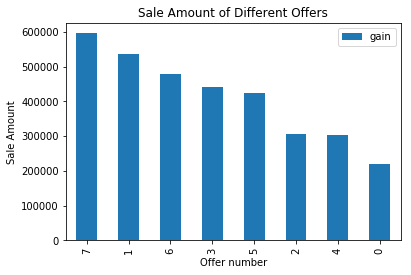

In [62]:
recommend_offer('0011e0d4e6b944f998e987f904e8c1e5', user_matrix, offer_matrix)

As the user is not in our data, top best sale offer recommendations are given
                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94
offer id: fafdcd668e3743c1bb461111dcafc2a4
offer id: 2298d6c36e964ae4a3e7e9706d1fb8c2
offer id: f19421c1d4aa40978ebb69ca19b0e20d
offer id: 4d5c57ea9a6940dd891ad53e9dbe8da0
offer id: ae264e3637204a6fb9bb56bc8210ddfd
offer id: 2906b810c7d4411798c6938adc9daaa5
offer id: 9b98b8c7a33c4b65b9aebfe6a799e6d9
offer id: 0b1e1539f2cc45b7b9fa7c272da2e1d7


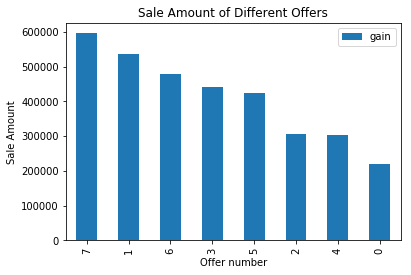

In [63]:
recommend_offer('new_user', user_matrix, offer_matrix)

In [64]:
def gender_offer(full_df):
   
    gender_res = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])
    gender_sent = pd.DataFrame(data=[[0,0],[0,0],[0,0]], index=['M', 'F', 'O'], columns=['bogo', 'discount'])

    # We count the number of offer completed base on the customer gender
    for offer_type in ['bogo', 'discount']:
        for offer_id in portfolio[portfolio['offer_type']==offer_type]['id']:
            # count the total number of customers responsed our offers.
            gender_res[offer_type] = gender_res[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[offer_type] = gender_sent[offer_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_res/ gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

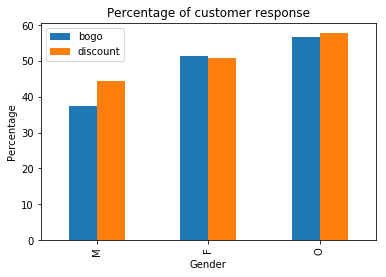

In [65]:
gender_offer(full_df)

In [82]:
cleaned_portfolio

,difficulty,duration,id,reward,web,email,mobile,social,bogo,discount,informational
0,10,168,ae264e3637204a6fb9bb56bc8210ddfd,10,0,1,1,1,1,0,0
1,10,120,4d5c57ea9a6940dd891ad53e9dbe8da0,10,1,1,1,1,1,0,0
2,0,96,3f207df678b143eea3cee63160fa8bed,0,1,1,1,0,0,0,1
3,5,168,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,1,1,1,0,1,0,0
4,20,240,0b1e1539f2cc45b7b9fa7c272da2e1d7,5,1,1,0,0,0,1,0
5,7,168,2298d6c36e964ae4a3e7e9706d1fb8c2,3,1,1,1,1,0,1,0
6,10,240,fafdcd668e3743c1bb461111dcafc2a4,2,1,1,1,1,0,1,0
7,0,72,5a8bc65990b245e5a138643cd4eb9837,0,0,1,1,1,0,0,1
8,5,120,f19421c1d4aa40978ebb69ca19b0e20d,5,1,1,1,1,1,0,0
9,10,168,2906b810c7d4411798c6938adc9daaa5,2,1,1,1,0,0,1,0


In [67]:
def gender_offer_channel(full_df):
    
    
    gender_response = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])
    gender_sent = pd.DataFrame(data=[[0,0,0,0],[0,0,0,0],[0,0,0,0]], index=['M', 'F', 'O'], columns=['web', 'email', 'mobile', 'social'])

    
    for channel_type in ['web', 'email', 'mobile', 'social']:
        for offer_id in cleaned_portfolio[(cleaned_portfolio[channel_type]==1)&(cleaned_portfolio['informational']!=1)]['id']:
            # count the total number of customers responsed our offers.
            gender_response[channel_type] = gender_response[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>0].index)]['gender'].value_counts(), fill_value=0)
            # count the total number of offer sent
            gender_sent[channel_type] = gender_sent[channel_type].add(profile[profile['id'].isin(full_df[full_df[offer_id]>=0].index)]['gender'].value_counts(), fill_value=0)
        
    gender_offer = (gender_response / gender_sent * 100).plot(kind='bar', title='Percentage of customer response')
    gender_offer.set_xlabel("Gender")
    gender_offer.set_ylabel("Percentage")

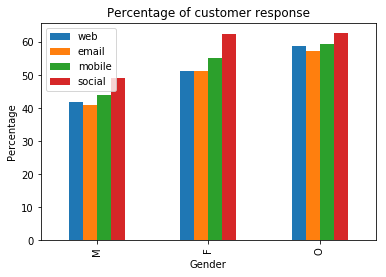

In [77]:
gender_offer_channel(full_df)

In [78]:
def best_sale_offer(user_item_matrix):
    # Find out which offer sells the best

    offer_gain = []
    for offer_id in user_item_matrix.columns:
        offer_gain.append([offer_id, transcript[(transcript['person'].isin(list(user_item_matrix[user_item_matrix[offer_id]>=1].index)))&(transcript['event']=='transaction')]['value'].apply(lambda x: x['amount']).sum()])

    offer_value = pd.DataFrame(offer_gain, columns=['offer_id', 'gain'])
    offer_value['gain'] = pd.to_numeric(offer_value['gain'])
    offer_value.sort_values(by='gain', ascending=False, inplace=True)
    print(offer_value)
    
    best_sale = offer_value.plot(kind='bar', title='Sale Amount of Different Offers')
    best_sale.set_xlabel('Offer number')
    best_sale.set_ylabel('Sale Amount')
    
    return offer_value

                           offer_id       gain
7  fafdcd668e3743c1bb461111dcafc2a4  596220.84
1  2298d6c36e964ae4a3e7e9706d1fb8c2  538027.98
6  f19421c1d4aa40978ebb69ca19b0e20d  480555.03
3  4d5c57ea9a6940dd891ad53e9dbe8da0  441918.93
5  ae264e3637204a6fb9bb56bc8210ddfd  423683.27
2  2906b810c7d4411798c6938adc9daaa5  305568.42
4  9b98b8c7a33c4b65b9aebfe6a799e6d9  304361.77
0  0b1e1539f2cc45b7b9fa7c272da2e1d7  218905.94


,offer_id,gain
7,fafdcd668e3743c1bb461111dcafc2a4,596220.84
1,2298d6c36e964ae4a3e7e9706d1fb8c2,538027.98
6,f19421c1d4aa40978ebb69ca19b0e20d,480555.03
3,4d5c57ea9a6940dd891ad53e9dbe8da0,441918.93
5,ae264e3637204a6fb9bb56bc8210ddfd,423683.27
2,2906b810c7d4411798c6938adc9daaa5,305568.42
4,9b98b8c7a33c4b65b9aebfe6a799e6d9,304361.77
0,0b1e1539f2cc45b7b9fa7c272da2e1d7,218905.94


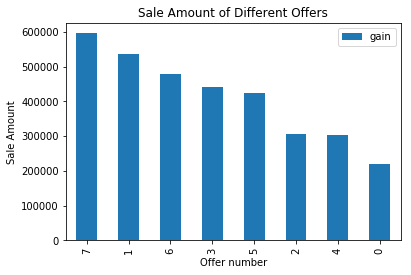

In [81]:
best_sale_offer(full_df)